In [1]:
# import the required packages
import numpy as np
import pandas as pd

# for modelling
import statsmodels.api as sm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate
import random
from math import sqrt
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from feature_engine.encoding import OrdinalEncoder

# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Load and Sample the data

In [2]:
# Enter your code here:
df = pd.read_csv('train_LZdllcl.csv') # Import dataset
df.head() # View first 5 records of the DataFrame

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [3]:
# View number of items and data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [4]:
# Check for null values in each column
df.isnull().any()

employee_id             False
department              False
region                  False
education                True
gender                  False
recruitment_channel     False
no_of_trainings         False
age                     False
previous_year_rating     True
length_of_service       False
KPIs_met >80%           False
awards_won?             False
avg_training_score      False
is_promoted             False
dtype: bool

In [5]:
df.isnull().mean()

employee_id             0.000000
department              0.000000
region                  0.000000
education               0.043953
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    0.075244
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64

In [6]:
# Check count of unique values in previous_year_rating
df.previous_year_rating.value_counts(dropna=False)

previous_year_rating
3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
NaN     4124
Name: count, dtype: int64

In [7]:
# Check count of unique values in previous_year_rating when length_of_service equal 1
df[df['length_of_service']==1]['previous_year_rating'].value_counts(dropna=False)

previous_year_rating
NaN    4124
3.0     158
4.0     114
5.0      64
1.0      44
2.0      43
Name: count, dtype: int64

In [8]:
# Check count of unique values in previous_year_rating when length_of_service not equal 1
df[df['length_of_service']!=1]['previous_year_rating'].value_counts(dropna=False)

previous_year_rating
3.0    18460
5.0    11677
4.0     9763
1.0     6179
2.0     4182
Name: count, dtype: int64

In [9]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


### Exploratory Data Analysis for Numerical Features

In [10]:
# find numerical variables
num_cols = [c for c in df.columns if df[c].dtypes !='O']

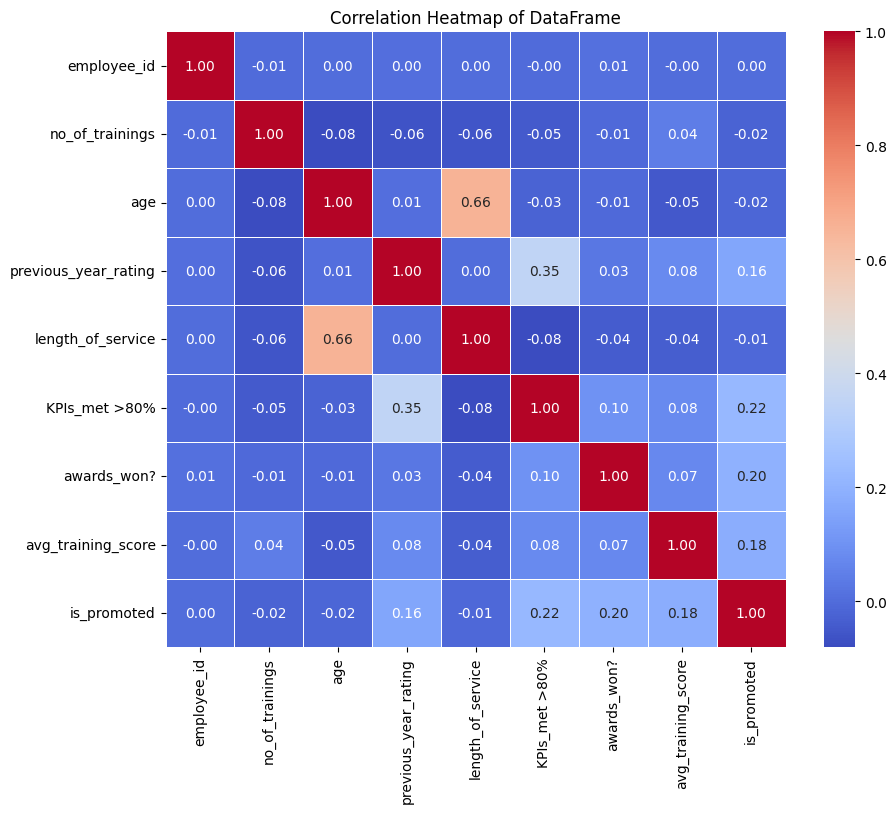

In [11]:
correlation_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8)) # Optional: Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame')
plt.show()

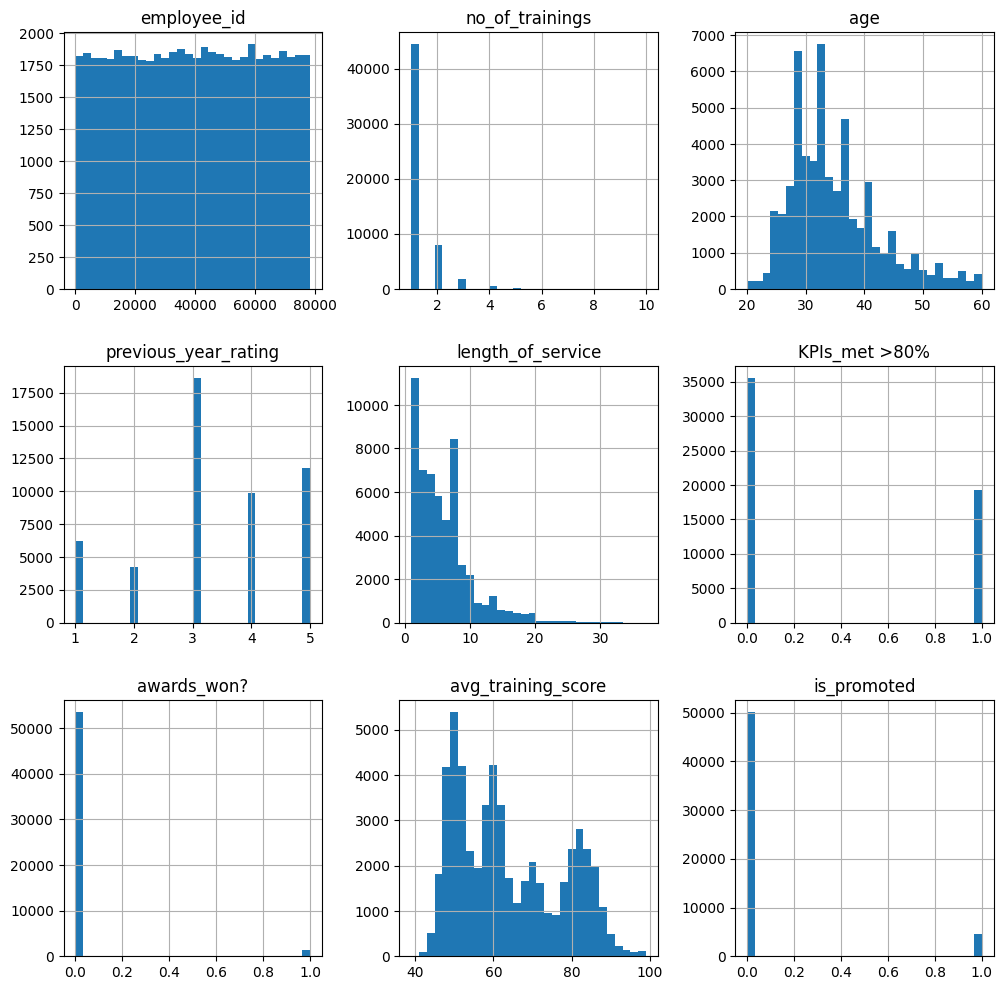

In [12]:
df.hist(bins=30, figsize=(12,12))
plt.show()

### Exploratory Data Analysis for Categorical Features

In [13]:
# find categorical variables
cat_cols = [c for c in df.columns if df[c].dtypes =='O']

In [14]:
for c in cat_cols:
    print(df[c].value_counts())
    print()

department
Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: count, dtype: int64

region
region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: count, dtype: int64

education
Bachelor's          36669
Mas

### Train-Test Split

In [15]:
dfy = df.is_promoted # model output
dfX = df.drop(['is_promoted', 'employee_id'], axis=1) # Model Inputs
dfX.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73


In [16]:
# Split both Inputs (X) and Output (y) into training set (70%) and testing set (30%)
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.3, random_state=2, stratify=dfy)

### Data Imputation

In [17]:
#let's create an arbitrary value imputer
arb_imputer = ArbitraryNumberImputer(
    arbitrary_number=3, variables=['previous_year_rating'])

arb_imputer.fit(X_train)

,arbitrary_number,3
,variables,['previous_year_rating']
,imputer_dict,None


In [18]:
# transform the data
X_train = arb_imputer.transform(X_train)
X_test = arb_imputer.transform(X_test)

In [19]:
cat_imputer = CategoricalImputer(variables=['education'])
cat_imputer.fit(X_train)

,imputation_method,'missing'
,fill_value,'Missing'
,variables,['education']
,return_object,False
,ignore_format,False


In [20]:
# transform the data
X_train = cat_imputer.transform(X_train)
X_test = cat_imputer.transform(X_test)

In [21]:
X_train.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
9196,HR,region_2,Master's & above,m,other,1,50,3.0,3,0,0,49
11719,Procurement,region_12,Bachelor's,f,sourcing,1,33,3.0,9,0,0,69
3389,Operations,region_27,Bachelor's,m,sourcing,1,37,1.0,9,0,0,61
34569,Sales & Marketing,region_28,Bachelor's,f,other,1,28,3.0,1,0,0,50
4722,Procurement,region_13,Bachelor's,m,other,1,45,4.0,6,0,0,70


In [22]:
X_train.isnull().mean()

department              0.0
region                  0.0
education               0.0
gender                  0.0
recruitment_channel     0.0
no_of_trainings         0.0
age                     0.0
previous_year_rating    0.0
length_of_service       0.0
KPIs_met >80%           0.0
awards_won?             0.0
avg_training_score      0.0
dtype: float64

### Categorical Data Encoding

In [23]:
# let's create the encoder
ordinal_enc = OrdinalEncoder(
    encoding_method='ordered',
    variables=cat_cols
)

In [24]:
ordinal_enc.fit(X_train, y_train)

,encoding_method,'ordered'
,variables,"['department', 'region', ...]"
,missing_values,'raise'
,ignore_format,False
,unseen,'ignore'


In [25]:
ordinal_enc.variables_

['department', 'region', 'education', 'gender', 'recruitment_channel']

In [26]:
ordinal_enc.encoder_dict_

{'department': {'Legal': 0,
  'HR': 1,
  'R&D': 2,
  'Sales & Marketing': 3,
  'Finance': 4,
  'Operations': 5,
  'Procurement': 6,
  'Analytics': 7,
  'Technology': 8},
 'region': {'region_9': 0,
  'region_34': 1,
  'region_24': 2,
  'region_33': 3,
  'region_29': 4,
  'region_5': 5,
  'region_32': 6,
  'region_6': 7,
  'region_18': 8,
  'region_21': 9,
  'region_11': 10,
  'region_20': 11,
  'region_31': 12,
  'region_26': 13,
  'region_19': 14,
  'region_12': 15,
  'region_10': 16,
  'region_16': 17,
  'region_8': 18,
  'region_14': 19,
  'region_27': 20,
  'region_30': 21,
  'region_15': 22,
  'region_2': 23,
  'region_13': 24,
  'region_1': 25,
  'region_3': 26,
  'region_7': 27,
  'region_28': 28,
  'region_22': 29,
  'region_23': 30,
  'region_25': 31,
  'region_17': 32,
  'region_4': 33},
 'education': {'Missing': 0,
  'Below Secondary': 1,
  "Bachelor's": 2,
  "Master's & above": 3},
 'gender': {'m': 0, 'f': 1},
 'recruitment_channel': {'other': 0, 'sourcing': 1, 'referred': 2

In [27]:
# let's transform train and test sets
X_train = ordinal_enc.transform(X_train)
X_test = ordinal_enc.transform(X_test)

### XGBoost Classifier

#### Base Model

In [28]:
# Build XGBoost Model and Evaluate accuracy
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=2
)

xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


#### Fine-tuning by Grid Search

In [29]:
# Determine hyperparameters to auto tune

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 5],
    'gamma': [0, 0.1, 0.3, 1, 3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [1, 2, 5, 10, 20],
}

In [30]:
# Train a base model
xgb_base = XGBClassifier(random_state=2)

# Train a second XGBoost Model "xgb_gscv" with "best" hyperparameters
xgb_gscv = GridSearchCV(estimator=xgb_base, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

# Fit the model to the training set
xgb_gscv = xgb_gscv.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(xgb_gscv.best_score_)
print(xgb_gscv.best_params_)

In [ ]:
# Train a base XGBoost Model "xgb_gs"
xgb_gs = XGBClassifier(n_estimators=300,
                       scale_pos_weight=2,
                       min_child_weight=1,
                       learning_rate=0.1,
                       max_depth=4,
                       subsample=1.0,
                       colsample_bytree=0.6,
                       gamma=0,
                       random_state=2,
                       n_jobs=-1)

# Fit the model to the training set
xgb_gs.fit(X_train,y_train)

#### Feature Selection by Feature Importance

In [ ]:
X_train.columns

In [ ]:
xgb_gs.feature_importances_

In [ ]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['feature']), 
           pd.DataFrame(xgb_gs.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

In [ ]:
# Select features by importance
important_features = ['avg_training_score', 'KPIs_met >80%', 'department',
                      'previous_year_rating', 'awards_won?']

# Filter training set and testing set by important features
X_train_fi_xgb = X_train[important_features]
X_test_fi_xgb = X_test[important_features]

In [ ]:
# Train a RandomForestClassifier "xgb_fi" 
xgb_fi = XGBClassifier(n_estimators=300,
                       scale_pos_weight=2,
                       min_child_weight=1,
                       learning_rate=0.1,
                       max_depth=4,
                       subsample=1.0,
                       colsample_bytree=0.6,
                       gamma=0,
                       random_state=2,
                       n_jobs=-1)

# Fit the model to the training set
xgb_fi.fit(X_train_fi_xgb, y_train)

#### Adjusting Input data by Scaling

In [ ]:
# set up the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train_fi_xgb)

In [ ]:
# transform train and test sets
X_train_scaled_xgb_fi = scaler.transform(X_train_fi_xgb)
X_test_scaled_xgb_fi = scaler.transform(X_test_fi_xgb)

In [ ]:
# Train a Random Forest Model "xgb_sc" 
xgb_sc = XGBClassifier(n_estimators=300,
                       scale_pos_weight=2,
                       min_child_weight=1,
                       learning_rate=0.1,
                       max_depth=4,
                       subsample=1.0,
                       colsample_bytree=0.6,
                       gamma=0,
                       random_state=2,
                       n_jobs=-1)

# Fit the model to the training set
xgb_sc.fit(X_train_scaled_xgb_fi, y_train)

#### Evaluate and Improve the Model(s)

In [ ]:
y_pred = xgb.predict(X_test)

# Various scores of XGBoost (Grid Search) 
print("Accuracy: %.2f" % metrics.accuracy_score(y_test, y_pred))
print("Precision: %.2f" % metrics.precision_score(y_test, y_pred))
print("Recall: %.2f" % metrics.recall_score(y_test, y_pred))
print("F1 score: %.2f" % metrics.f1_score(y_test, y_pred))

In [ ]:
y_pred_gs = xgb_gs.predict(X_test)

# Various scores of XGBoost (Grid Search) 
print("Accuracy: %.2f" % metrics.accuracy_score(y_test, y_pred_gs))
print("Precision: %.2f" % metrics.precision_score(y_test, y_pred_gs))
print("Recall: %.2f" % metrics.recall_score(y_test, y_pred_gs))
print("F1 score: %.2f" % metrics.f1_score(y_test, y_pred_gs))

In [ ]:
y_pred_fi = xgb_fi.predict(X_test_fi_xgb)

# Various scores of XGBoost (Grid Search) 
print("Accuracy: %.2f" % metrics.accuracy_score(y_test, y_pred_fi))
print("Precision: %.2f" % metrics.precision_score(y_test, y_pred_fi))
print("Recall: %.2f" % metrics.recall_score(y_test, y_pred_fi))
print("F1 score: %.2f" % metrics.f1_score(y_test, y_pred_fi))

In [ ]:
y_pred_sc = xgb_sc.predict(X_test_scaled_xgb_fi)

# Various scores of XGBoost (Grid Search) 
print("Accuracy: %.2f" % metrics.accuracy_score(y_test, y_pred_sc))
print("Precision: %.2f" % metrics.precision_score(y_test, y_pred_sc))
print("Recall: %.2f" % metrics.recall_score(y_test, y_pred_sc))
print("F1 score: %.2f" % metrics.f1_score(y_test, y_pred_sc))

### Evaluate the Best Model using Confusion Matrix

In [ ]:
# Use the best model to perform prediction on test data
y_pred = xgb_gs.predict(X_test) # returns 0 or 1

# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

ConfusionMatrixDisplay(confusion_matrix=cnf_matrix).plot()